In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = mass
        self.dt = dt
        self.total_time = total_time
        self.time_steps = int(total_time / dt)

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # To store trajectory

    def forces(self):
        # Calculate the spring forces between particles
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                displacement = self.positions[j] - self.positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement / distance
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-Reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))
        
        # Calculate forces
        F = self.forces()
        
        # Equations of motion
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = (F / self.mass).flatten()  # d(velocity)/dt = force/mass
        
        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)
        
        # Integrate the equations of motion
        solution = odeint(self.motion_equations, initial_conditions, t)
        
        # Extract positions from the solution and store in trajectory
        self.trajectory = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        return self.trajectory

    def generate_transition_matrix(self):
    # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))
    
    # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    if i != j:
                        displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t, j])
                        cumulative_displacements[i, j] += displacement

    # Use cumulative displacement to adjust transition probabilities (closer -> higher probability)
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                    if i != j and cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / (cumulative_displacements[i, j] ** 2)  # Added scaling factor

    # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix


def generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix, target_volatilities):
    # Ensure the correlation matrix is positive definite
    assert np.all(np.linalg.eigvals(target_corr_matrix) > 0), "The correlation matrix must be positive definite."
    
    # Perform Cholesky decomposition on the correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)

    # Generate transition matrix from the polymer model based on trajectory
    transition_matrix = polymer_model.generate_transition_matrix()

    # Generate independent random walks using the transition matrix from the polymer model
    independent_walks = np.zeros((num_walks, num_steps))
    for i in range(num_walks):
        state = np.random.choice(polymer_model.num_particles)  # Random initial state
        walk = [state]
        for _ in range(num_steps - 1):
            state = np.random.choice(polymer_model.num_particles, p=transition_matrix[state])
            walk.append(state)
        independent_walks[i] = np.array(walk)

    # Apply volatilities to scale the independent walks
    scaled_walks = independent_walks * target_volatilities.reshape(-1, 1)

    # Generate correlated random walks using Cholesky matrix L
    correlated_walks = L @ scaled_walks

    return correlated_walks

In [2]:
# Parameters
num_walks = 3          # Number of random walks
num_steps = 500        # Number of steps in each walk
target_volatilities = np.array([0.2, 0.5, 0.3])  # Desired volatilities for each walk

# High correlation matrix
target_corr_matrix = np.array([[1.0, 0.8, 0.6],
                               [0.8, 1.0, 0.4],
                               [0.6, 0.4, 1.0]])

# Initialize the polymer model
polymer_model = PolymerMotion(num_particles=5, spring_constants=np.random.rand(5))

# Simulate polymer motion
polymer_model.simulate()

# Generate correlated random walks using the polymer model transition matrix
random_walks = generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix, target_volatilities)

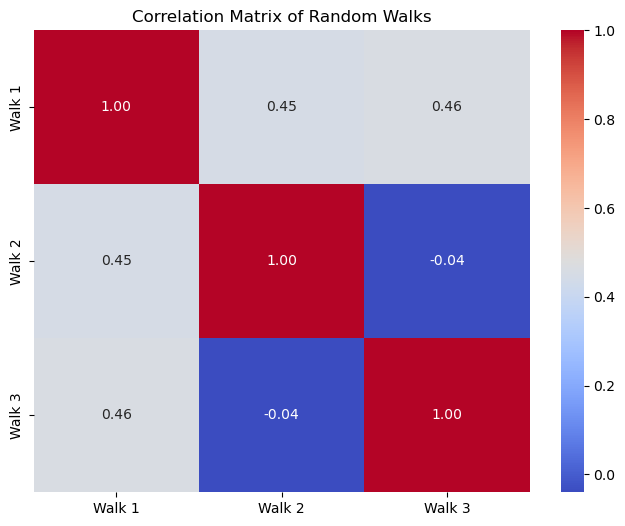

In [3]:
# Calculate and plot the correlation matrix from the random walks
correlation_matrix = np.corrcoef(random_walks)

# Plot the calculated correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            xticklabels=[f'Walk {i+1}' for i in range(num_walks)],
            yticklabels=[f'Walk {i+1}' for i in range(num_walks)])
plt.title('Correlation Matrix of Random Walks')
plt.show()

In [4]:
def rescale_to_limits(data, lower_limit, upper_limit):

    min_val = np.min(data)
    max_val = np.max(data)

    # Rescale using min-max normalization
    rescaled_data = (data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    rescaled_data = rescaled_data * (upper_limit - lower_limit) + lower_limit  # Scale to [lower_limit, upper_limit]
    
    return rescaled_data

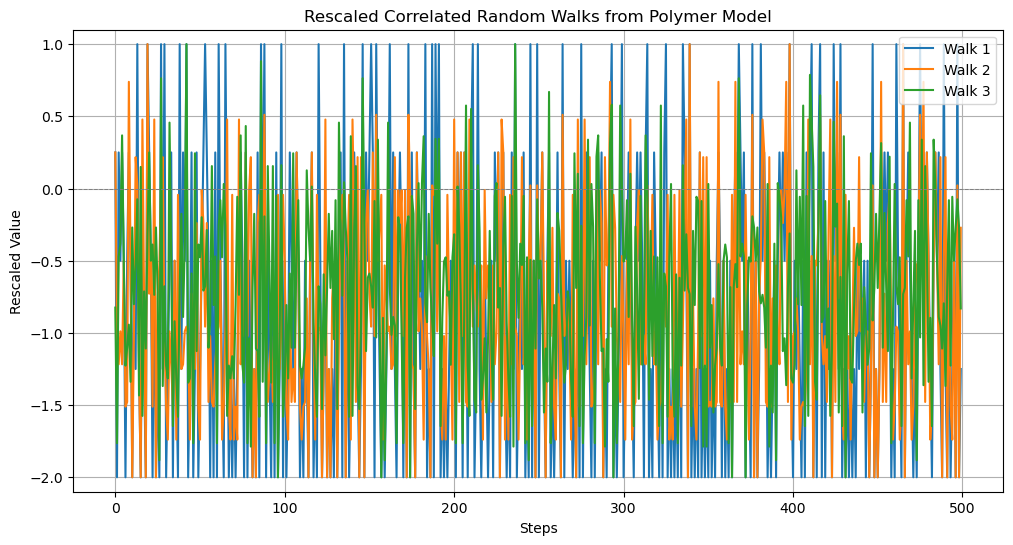

In [5]:
# Rescale each random walk to the range [lower_limit, upper_limit]
lower_limit = -2  # Specify the lower limit
upper_limit = 1   # Specify the upper limit

plt.figure(figsize=(12, 6))

for i in range(random_walks.shape[0]):
    rescaled_walk = rescale_to_limits(random_walks[i], lower_limit, upper_limit)
    plt.plot(rescaled_walk, label=f'Walk {i+1}')

plt.title('Rescaled Correlated Random Walks from Polymer Model')
plt.xlabel('Steps')
plt.ylabel('Rescaled Value')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Add a line at y=0 for reference
plt.legend()
plt.grid()
plt.ylim(lower_limit - 0.1, upper_limit + 0.1)  # Adjust limits for better visibility
plt.show()